In [2]:
import laserhockey.hockey_env as h_env
from importlib import reload

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import pylab as plt
import time
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import dueling_memory as mem
from dueling_feedforward import Feedforward

In [3]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# DQN Implementation #

In [4]:
class QFunction(Feedforward):
    def __init__(self, observation_dim, action_dim, hidden_sizes=[100,100], 
                 learning_rate = 0.0002):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, 
                         output_size=action_dim)
        self.optimizer=torch.optim.Adam(self.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        self.loss = torch.nn.SmoothL1Loss() # MSELoss()
    
    def fit(self, observations, actions, targets):
        self.train() # put model in training mode
        self.optimizer.zero_grad()
        # Forward pass
        acts = torch.from_numpy(actions)
        pred = self.Q_value(torch.from_numpy(observations).float(), acts)
        # Compute Loss
        loss = self.loss(pred, torch.from_numpy(targets).float())
        
        # Backward pass
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def Q_value(self, observations, actions):
        return self.forward(observations).gather(1, actions[:,None])        
    
    def maxQ(self, observations):
        return np.max(self.predict(observations), axis=-1, keepdims=True)
        
    def greedyAction(self, observations):
        return np.argmax(self.predict(observations), axis=-1)

In [8]:
class DQNAgent(object):
    """
    Agent implementing Q-learning with NN function approximation.    
    """
    def __init__(self, observation_space, action_space, **userconfig):
        
        if not isinstance(observation_space, spaces.box.Box):
            raise UnsupportedSpace('Observation space {} incompatible ' \
                                   'with {}. (Require: Box)'.format(observation_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise UnsupportedSpace('Action space {} incompatible with {}.' \
                                   ' (Reqire Discrete.)'.format(action_space, self))
        
        self._observation_space = observation_space
        self._action_space = action_space
        self._action_n = action_space.n
        self._config = {
            "eps": 0.05,            # Epsilon in epsilon greedy policies                        
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002,
            "update_target_every": 20,
            "use_target_net":True
        }
        self._config.update(userconfig)        
        self._eps = self._config['eps']
        
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])
                
        # Q Network
        self.Q = QFunction(observation_dim=self._observation_space.shape[0], 
                           action_dim=self._action_n,
                           learning_rate = self._config["learning_rate"])
        # Q Network
        self.Q_target = QFunction(observation_dim=self._observation_space.shape[0], 
                                  action_dim=self._action_n,
                                  learning_rate = 0)
        self._update_target_net()
        self.train_iter = 0
            
    def _update_target_net(self):        
        self.Q_target.load_state_dict(self.Q.state_dict())

    def act(self, observation, eps=None):
        if eps is None:
            eps = self._eps
        # epsilon greedy
        if np.random.random() > eps:
            action = self.Q.greedyAction(observation)
        else: 
            action = self._action_space.sample()        
        return action
    
    def store_transition(self, transition):
        self.buffer.add_transition(transition)
            
    def train(self, iter_fit=32):
        losses = []
        self.train_iter+=1
        if self._config["use_target_net"] and self.train_iter % self._config["update_target_every"] == 0:
            self._update_target_net()                
        for i in range(iter_fit):

            # sample from the replay buffer
            data=self.buffer.sample(batch=self._config['batch_size'])
            s = np.stack(data[:,0]) # s_t
            a = np.stack(data[:,1]) # a_t
            rew = np.stack(data[:,2])[:,None] # rew  (batchsize,1)
            s_prime = np.stack(data[:,3]) # s_t+1
            done = np.stack(data[:,4])[:,None] # done signal  (batchsize,1)
            
            if self._config["use_target_net"]:
                v_prime = self.Q_target.maxQ(s_prime)
            else:
                v_prime = self.Q.maxQ(s_prime)
            # target
            gamma=self._config['discount']                                                
            td_target = rew + gamma * (1.0-done) * v_prime
            
            # optimize the lsq objective
            fit_loss = self.Q.fit(s, a, td_target)
            
            losses.append(fit_loss)
                
        return losses

# Set ENV #

In [66]:
np.set_printoptions(suppress=True)
reload(h_env)
env = h_env.HockeyEnv() #mode=h_env.HockeyEnv.TRAIN_DEFENSE
opponent = h_env.BasicOpponent()
strong_opponent = h_env.BasicOpponent(weak=False)

In [67]:
obs,info = env.reset()
print(obs, info)
obs_agent2 = env.obs_agent_two()
# _ = env.render(mode = "human")

ac_space = env.discrete_action_space
o_space = env.observation_space
print(ac_space)
print(o_space)
layer_sizes = [ac_space] + [100,100]
layer_construction_list = [(i, o) for i,o in zip(layer_sizes[:-1], layer_sizes[1:])]
print(list(zip(env.observation_space.low, env.observation_space.high)))

[-3.          0.          0.          0.          0.          0.
  3.          0.          0.          0.          0.          0.
  1.17606926 -0.65795279  0.          0.          0.          0.        ] {'winner': 0, 'reward_closeness_to_puck': 0, 'reward_touch_puck': 0.0, 'reward_puck_direction': 0.0}
Discrete(7)
Box(-inf, inf, (18,), float32)
[(-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf)]


In [87]:
use_target = True
target_update = 20
learning_rate = 0.00001
epsilon = 0.1
disc = 0.975
q_agent = DQNAgent(o_space, ac_space, discount=disc, eps=epsilon, 
                   use_target_net=use_target, update_target_every= target_update, learning_rate=learning_rate)
stats = []
losses = []

18 100 100 7
18 100 100 7


# Train Shooting #

In [41]:
env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_SHOOTING)
max_episodes=500
max_steps=600
flag = False

for i in range(max_episodes):
    env.reset()  
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        #env.render()
        done = False        
        a1_discrete = q_agent.act(ob)   # changed for laserhockey , eps=0.0
        a1_continuous = env.discrete_to_continous_action(a1_discrete) # changed for laserhockey
        a2 = [0,0.,0,0 ]
        #a2 = opponent.act(obs_agent2)
        (ob_new, reward, done, trunc, _info) = env.step(np.hstack([a1_continuous, a2]))
        total_reward += reward
        q_agent.store_transition((ob, a1_discrete, reward, ob_new, done))
        ob = ob_new
        #obs_agent2 = env.obs_agent_two()
        if done: break
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])  
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))
        if flag: print("     mean reward over last 20 eisodes: {}".format(sum([x[1] for x in stats[i-20:i]])/20))# sum(stats[(i-20):i][1])/20))
        flag = True

1: Done after 81 steps. Reward: -8.35658249502041
21: Done after 81 steps. Reward: -21.970411179217923
     mean reward over last 20 eisodes: -24.850496687057404
41: Done after 81 steps. Reward: -25.603863746000723
     mean reward over last 20 eisodes: -23.052250153271448
61: Done after 81 steps. Reward: -44.4235561502175
     mean reward over last 20 eisodes: -21.19504750602983
81: Done after 81 steps. Reward: -3.0130854579247197
     mean reward over last 20 eisodes: -21.403479996653036
101: Done after 81 steps. Reward: -20.69169960065881
     mean reward over last 20 eisodes: -19.939355747749595
121: Done after 81 steps. Reward: -7.959299430108213
     mean reward over last 20 eisodes: -20.32742234465251
141: Done after 81 steps. Reward: -2.3819521532804573
     mean reward over last 20 eisodes: -15.659817779551364
161: Done after 81 steps. Reward: -16.083506352759283
     mean reward over last 20 eisodes: -8.56671035060521
181: Done after 81 steps. Reward: -5.287253183090827
     

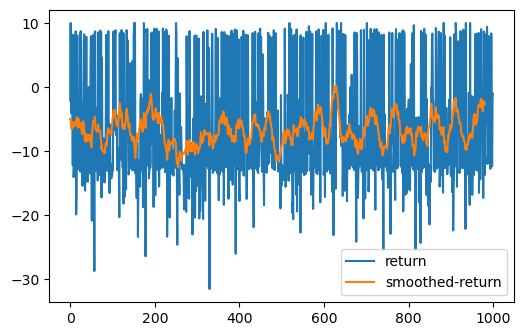

In [82]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

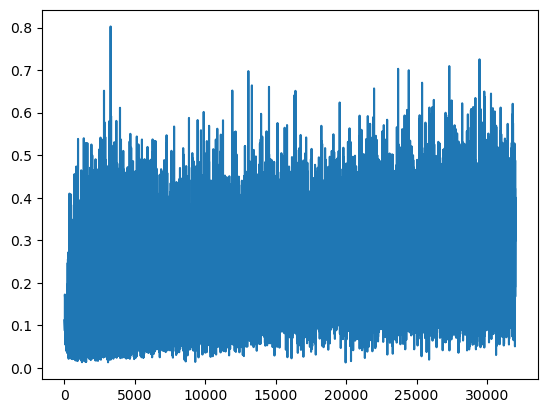

In [83]:
plt.figure()
plt.plot(losses_np)

In [84]:
test_stats = []
episodes=5
max_steps=600
#env_ = env    # without rendering
 # with rendering

for i in range(episodes):
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        env.render()
        done = False        
        a = env.discrete_to_continous_action(q_agent.act(ob, eps=0.0))
        a2 = opponent.act(obs_agent2)
        (ob_new, reward, done, trunc, _info) = env.step(np.hstack([a, a2]))
        total_reward+= reward
        ob=ob_new        
        obs_agent2 = env.obs_agent_two()
        if done: break    
    test_stats.append([i,total_reward,t+1])     

In [20]:
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))

-7.820310660830029 +- 15.120234349437437


# Train Defending #

In [94]:
env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_DEFENSE)
max_episodes=1000
max_steps=100
flag = False
max_eps = 0.5
min_eps = 0.05
eps_desc = (max_eps - min_eps)/max_episodes
eps = max_eps

for i in range(max_episodes):
    
    env.reset()  
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        #env.render()
        done = False        
        a1_discrete = q_agent.act(ob, eps=eps)   # changed for laserhockey , eps=0.0
        a1_continuous = env.discrete_to_continous_action(a1_discrete) # changed for laserhockey
        a2 = [0,0.,0,0 ]
        #a2 = opponent.act(obs_agent2)
        (ob_new, reward, done, trunc, _info) = env.step(np.hstack([a1_continuous, a2]))
        total_reward += reward
        q_agent.store_transition((ob, a1_discrete, reward, ob_new, done))
        ob = ob_new
        #obs_agent2 = env.obs_agent_two()
        if done: break
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])  
    eps = eps-eps_desc
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {} epsilon: {}".format(i, t+1, total_reward, eps))
        if flag: print("     mean reward over last 20 eisodes: {}".format(sum([x[1] for x in stats[i-20:i]])/20))# sum(stats[(i-20):i][1])/20))
        flag = True

1: Done after 8 steps. Reward: -12.410627771289331


KeyboardInterrupt: 

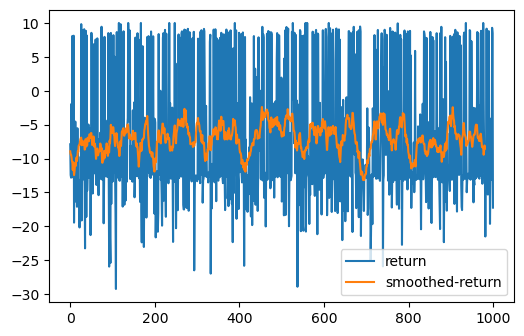

In [91]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

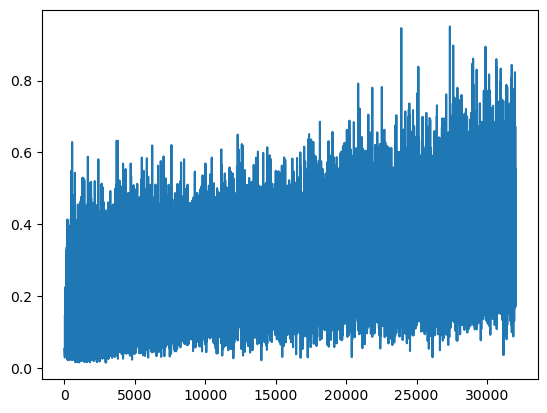

In [92]:
plt.figure()
plt.plot(losses_np)

In [93]:
test_stats = []
episodes=5
max_steps=1000

for i in range(episodes):
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        env.render()
        done = False        
        a = env.discrete_to_continous_action(q_agent.act(ob, eps=0.0))
        a2 = opponent.act(obs_agent2)
        (ob_new, reward, done, trunc, _info) = env.step(np.hstack([a, a2]))
        total_reward+= reward
        ob=ob_new        
        obs_agent2 = env.obs_agent_two()
        if done: break    
    test_stats.append([i,total_reward,t+1]) 
    
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))

-5.671046900060196 +- 7.017365325502751


# Train against weak opponent #

In [77]:
env = h_env.HockeyEnv(mode=h_env.HockeyEnv.NORMAL)
max_episodes=500
max_steps=500
flag = False

for i in range(max_episodes):
    env.reset()  
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        #env.render()
        done = False        
        a1_discrete = q_agent.act(ob)   # changed for laserhockey , eps=0.0
        a1_continuous = env.discrete_to_continous_action(a1_discrete) # changed for laserhockey
        #a2 = [0,0.,0,0 ]
        a2 = opponent.act(obs_agent2)
        (ob_new, reward, done, trunc, _info) = env.step(np.hstack([a1_continuous, a2]))
        total_reward += reward
        q_agent.store_transition((ob, a1_discrete, reward, ob_new, done))
        ob = ob_new
        obs_agent2 = env.obs_agent_two()
        if done: break
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])  
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))
        if flag: print("     mean reward over last 20 eisodes: {}".format(sum([x[1] for x in stats[i-20:i]])/20))# sum(stats[(i-20):i][1])/20))
        flag = True

1: Done after 251 steps. Reward: -39.303890827495195
21: Done after 74 steps. Reward: -13.10750328031727
     mean reward over last 20 eisodes: -30.8910420688116
41: Done after 251 steps. Reward: -42.261191254676326
     mean reward over last 20 eisodes: -24.746692137892587
61: Done after 251 steps. Reward: -42.014709107327164
     mean reward over last 20 eisodes: -26.331875528643394
81: Done after 251 steps. Reward: -43.529530676673666
     mean reward over last 20 eisodes: -37.219708317501286
101: Done after 174 steps. Reward: -17.549327448685943
     mean reward over last 20 eisodes: -25.34337781984073
121: Done after 251 steps. Reward: -26.340825629596193
     mean reward over last 20 eisodes: -21.831829560553757
141: Done after 87 steps. Reward: -17.580767787856843
     mean reward over last 20 eisodes: -19.0026046288894
161: Done after 158 steps. Reward: -15.1003950687129
     mean reward over last 20 eisodes: -14.29732023971491
181: Done after 251 steps. Reward: -27.29119593720

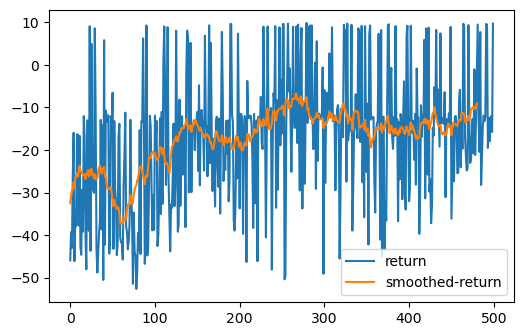

In [78]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

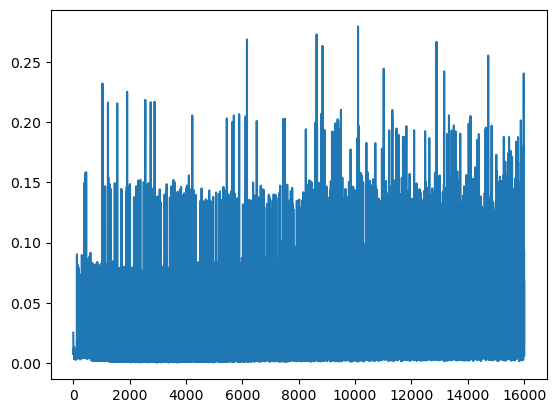

In [79]:
plt.figure()
plt.plot(losses_np)

In [57]:
test_stats = []
episodes=10
max_steps=600

for i in range(episodes):
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        env.render()
        done = False        
        a = env.discrete_to_continous_action(q_agent.act(ob, eps=0.0))
        a2 = opponent.act(obs_agent2)
        (ob_new, reward, done, trunc, _info) = env.step(np.hstack([a, a2]))
        total_reward+= reward
        ob=ob_new        
        obs_agent2 = env.obs_agent_two()
        if done: break    
    test_stats.append([i,total_reward,t+1]) 
    
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))

KeyboardInterrupt: 